In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2

import pywt

import keras
from keras import backend as K
from keras.models import model_from_json
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras import regularizers, optimizers, losses, initializers

import tensorflow as tf
from tensorflow.python.client import device_lib

import skimage
from skimage import measure

from PIL import Image

Using TensorFlow backend.


In [2]:
from srcnn import *
from utility import *

%matplotlib inline

In [3]:
#Division by 4
window_size= 64
scale = 4
stride = 16

In [4]:
def calcPSNR(original,prediction):
    return measure.compare_psnr(original, prediction,data_range=256)

In [5]:
def calcSSIM(orig,pred):
    return measure.compare_ssim(orig,pred,data_range=256, multichannel=True)

In [6]:
def calcMSE(orig,pred):
    return measure.compare_mse(orig,pred)

In [7]:
#Returns original, bicubic and model prediction
def getImages(filename):
    im = Image.open("set14/"+filename)

    img = np.asarray(im.convert('YCbCr'))

    img = img[:,:,0]
    org, bic = get_input_images(img, 4)

    h, w = retSize(org)

    sub_img = getSubImages(bic)
    
    low_w = []
    for i in range(len(sub_img)):
        dwt_w = pywt.dwt2(sub_img[i], 'haar')

        dwt_w = np.asfarray([dwt_w[0], dwt_w[1][0], dwt_w[1][1], dwt_w[1][2]])

        low_w.append(dwt_w)
        
    low_wavelet = np.asarray(low_w)
    
    pred_w = model.predict(low_wavelet)
    
    res = low_wavelet + pred_w

    sub_imgs = []
    for i in range(len(res)) :
        patch = res[i]
        dwt = (patch[0], (patch[1], patch[2], patch[3]))
        wavelet = pywt.idwt2(dwt, 'haar')
        sub_imgs.append(wavelet)
        
    im = patch_to_image(sub_imgs, h, w)
    return org,bic,im

In [8]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]
	
	#Display images
def print_luminance(img, ch=1) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')
		
def getSubImage(img, height, width, centerX, centerY, len_interval, scale = 1) :
    window = window_size // scale
    return img[ height   : height//2 + window + centerX*len_interval,
                width // 2  + centerY*len_interval : width//2 + window + centerY*len_interval : ]
				
def retSize(x):
    return (x.shape[0], x.shape[1])
	
def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

def equals(a, b) :
    t = a == b
    count = 0
    for a in range(0, len(t)) :
        for b in range(len(t[0])) :
            for c in range(len(t[1])) :
                if ( t[a, b, c] == False):
                    count = count + 1
    return count / (32*32*4) < 0.20
    

def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

def plot4images(im1, im2, im3, im4, ch=1) :
    size = (10, 10)
    fig = plt.figure(figsize=size)
    
    plt.subplot(221)
    plt.title("Approximation")
    print_luminance(im1, ch )
    plt.subplot(222)
    plt.title("Horizontal")
    print_luminance(im2, ch)
    plt.subplot(223)
    plt.title("Vertical")
    print_luminance(im3, ch)
    
    plt.subplot(224)
    plt.title("Diagonal")
    print_luminance(im4, ch)

def plot_waveletTrans(wt, ch=1) :
    plot4images(wt[0], wt[1][0], wt[1][1], wt[1][2], ch)



In [9]:
PATH = ""
TRAIN_FILE = PATH + "set14/"
obj_files = sorted(listdir(TRAIN_FILE )) #the filenames  the call to sorted is actually necessary to ensure independence to filesystems

In [10]:
high_res=obj_files[0::2]
low_res=obj_files[1::2]

In [11]:
model_grey = load_model("SRCNN_deep")
#model.summary()

In [12]:
model_r = load_model("SRCNN_red_channel")
model_g = load_model("SRCNN_green_channel")
model_b = load_model("SRCNN_blue_channel")
model_space= load_model("sptial_deep_model")

In [13]:
#This method assumes it gets a picture with mirror padding.
#It basically recreates said picture from patches and then crops accordingly to get back the good picture
def patch_to_image(patches, height, width, strides=stride, window_size=64) :
    count = 0
    if(len(patches[0].shape) == 3):
        img = np.zeros((int(np.ceil(height/stride))*window_size, int(np.ceil(width/stride))*window_size,3))
    else:
        img = np.zeros((int(np.ceil(height/stride))*window_size, int(np.ceil(width/stride))*window_size))    
    for h in range(0, height, stride) :
        for w in range (0, width, stride) : 
            if(len(patches[count].shape) == 3):
                img[h : h + window_size, w : w + window_size,:] = patches[count]
            else:
                img[h : h + window_size, w : w + window_size,] = patches[count]
            count = count + 1
    return img[:height, :width]

#This method basically takes a picture and applies mirror-folding boundary conditions to it.
#This way, we actually don't have to put "black" pixels when near borders, which is better for our transforms
def getSubImages(image, stride = stride, window_size=64) :
    sub = []
    height, width = retSize(image)
    moar = False
    if(len(image.shape) == 3):
        moar= True
    for h in range(0, height, stride) :
        for w in range (0, width, stride) : 
            x = h+window_size
            y = w+window_size
            i = h
            j = w
            concatX = False
            concatY = False
            if(x >= height):
                x = x-height
                if(y>= width):
                    y = y-width
                    i1 = image[h:height, w:width, :] if moar else image[h:height, w:width]
                    i2 = np.flip(image,axis=1)[h:height,0:y,:] if moar else np.flip(image,axis=1)[h:height,0:y]
                    i3 = np.flip(np.flip(image, axis=0), axis=1)[0:x,0:y,:] if moar else np.flip(np.flip(image, axis=0), axis=1)[0:x,0:y]
                    i4 = np.flip(image, axis=0)[0:x, w:width,:] if moar else np.flip(image, axis=0)[0:x, w:width] 
                    e = np.concatenate((np.concatenate((i1,i2), axis=1),np.concatenate((i3,i4), axis=1)), axis=0)
                else:
                    a = image[h:height, w:y, :] if moar else image[h:height, w:y]
                    b = np.flip(image, axis=0)[0:x, w:y,:] if moar else np.flip(image, axis=0)[0:x, w:y]
                    e = np.concatenate((a,b), axis=0)
            elif(y >= width):
                y = y-width
                a = image[h:x, w:width,:] if moar else image[h:x, w:width]
                b = np.flip(image,axis=1)[h:x, 0:y,:] if moar else np.flip(image,axis=1)[h:x, 0:y]
                e = np.concatenate((a,b), axis=1)
            else:
                e = image[h:x, w:y,:] if moar else image[h:x, w:y]
            sub.append(e)
    return sub


#Returns original, bicubic and model prediction

def getSpacePred(org, bic, modelspace):
    h, w = retSize(bic)
    if(len(bic.shape) != 3): #meaning we've a greyscale image
        bic = np.stack((bic,bic,bic), axis=2)
    sub_img = getSubImages(bic,window_size=32)
    print(np.asarray(sub_img).shape)
    
    pred_s = modelspace.predict(np.asarray(sub_img),64)
    
    im_sp = patch_to_image(pred_s, h, w, window_size=32)
    return im_sp#np.uint8((im-np.min(im))/(np.max(im)-np.min(im))*255)

def getImages(img, modelfreq):
    org, bic = get_input_images(img, 4)

    h, w = retSize(org)

    sub_img = getSubImages(bic)
    
    low_w = []
    for i in range(len(sub_img)):
        dwt_w = pywt.dwt2(sub_img[i], 'haar')

        dwt_w = np.asfarray([dwt_w[0], dwt_w[1][0], dwt_w[1][1], dwt_w[1][2]])

        low_w.append(dwt_w)
        
    low_wavelet = np.asarray(low_w)
    
    pred_w = modelfreq.predict(low_wavelet)
    
    res = low_wavelet + pred_w
    
    
    sub_imgs = []
    for i in range(len(res)) :
        patch = res[i]
        dwt = (patch[0], (patch[1], patch[2], patch[3]))
        wavelet = pywt.idwt2(dwt, 'haar')
        sub_imgs.append(wavelet)
        
    im = patch_to_image(sub_imgs, h, w)
    return org,bic, im#np.uint8((im-np.min(im))/(np.max(im)-np.min(im))*255)

def getColourImages(filename):
    img = Image.open("set14/"+filename)
    img = np.asarray(img)
    if(len(img.shape) == 3):
        im_r = img[:,:,0]
        im_g = img[:,:,1]
        im_b = img[:,:,2]
        org_r, bic_r, im_r = getImages(im_r,model_r)
        org_g, bic_g, im_g = getImages(im_g,model_g)
        org_b, bic_b, im_b = getImages(im_b,model_b)
        org = np.stack((org_r, org_g, org_b), axis=2)
        bic = np.stack((bic_r, bic_g, bic_b), axis=2)
        im = np.stack((im_r, im_g, im_b), axis=2)
    else:
        im = Image.open("set14/"+filename)
        img = np.asarray(im.convert('YCbCr'))
        org, bic,im= getImages(img[:,:,0],model_grey)

    space_pred = getSpacePred(org, bic, model_space)
    
    return org, bic, im, space_pred
    

In [14]:
results=[]

for f in high_res:
    print(f)
    org,bic,pred, space_pred=getColourImages(f)
    if(len(org.shape) != 3):
        space_pred = space_pred[:,:,0]
    results.append((org,bic,pred, space_pred))

img_001_SRF_4_HR.png
(960, 32, 32, 3)
img_002_SRF_4_HR.png
(1620, 32, 32, 3)
img_003_SRF_4_HR.png
(1024, 32, 32, 3)
img_004_SRF_4_HR.png
(396, 32, 32, 3)
img_005_SRF_4_HR.png
(368, 32, 32, 3)
img_006_SRF_4_HR.png
(324, 32, 32, 3)
img_007_SRF_4_HR.png
(736, 32, 32, 3)
img_008_SRF_4_HR.png
(396, 32, 32, 3)
img_009_SRF_4_HR.png
(1024, 32, 32, 3)
img_010_SRF_4_HR.png
(1024, 32, 32, 3)
img_011_SRF_4_HR.png
(1536, 32, 32, 3)
img_012_SRF_4_HR.png
(1024, 32, 32, 3)
img_013_SRF_4_HR.png
(1353, 32, 32, 3)
img_014_SRF_4_HR.png
(925, 32, 32, 3)


In [15]:
def convertToPicture(img):
    if(len(img.shape) == 3):
        img = Image.fromarray(img, 'RGB')
    else:
        img = Image.fromarray(img)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

In [16]:
i=0
ims = []
for res in results:
    im_w = convertToPicture(np.uint8(np.clip(res[2],0,255)))
    im_s = convertToPicture(np.uint8(np.clip(res[3],0,255)))
    im_w.save("srcnn_results/"+str(i)+".png")
    i=i+1
    ims.append((convertToPicture(res[0]), convertToPicture(res[1]),im_w, im_s))

In [17]:
def plot_results(i):
    result=results[i]
    org=result[0].astype(float)
    bic=result[1].astype(float)
    sr=result[2].astype(float)
    spred=result[3].astype(float)
    
    psnr_bic=round(calcPSNR(org,bic),4)
    psnr_sr=round(calcPSNR(org,sr),4)
    psnr_sd=round(calcPSNR(org, spred),4)
    org,bic,sr, spred = ims[i]
    
    plot_images([org,bic,sr, spred], ["Original", "Bic (PSNR: "+str(psnr_bic)+")", "SR (PSNR: "+str(psnr_sr)+")", "Spatial (PSNR: "+str(psnr_sd)+")"], size= (20,20), ch=1)

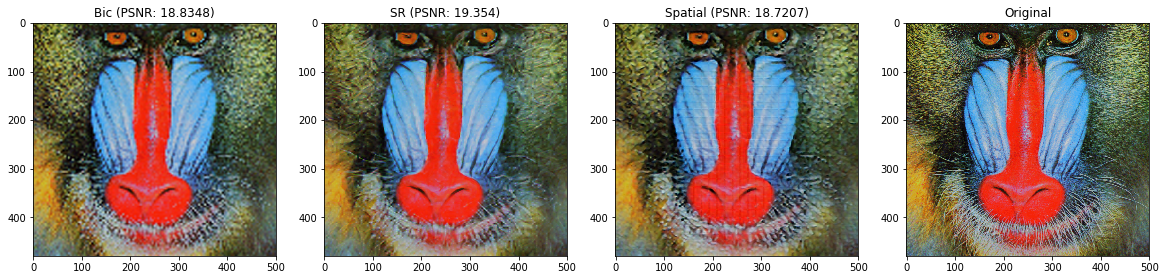

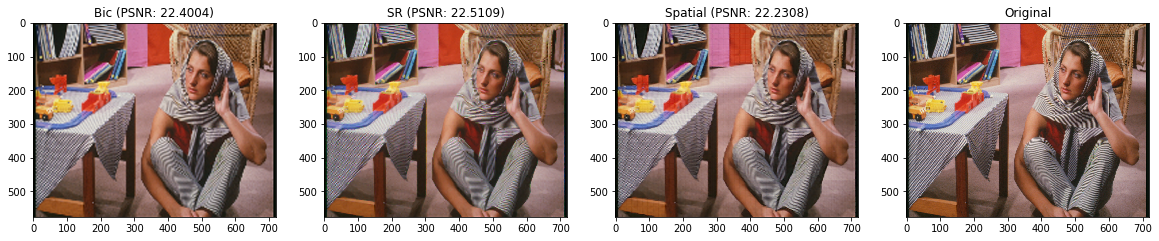

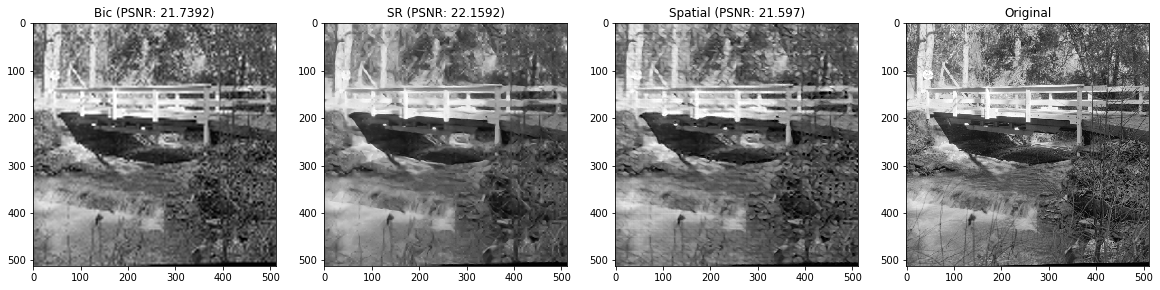

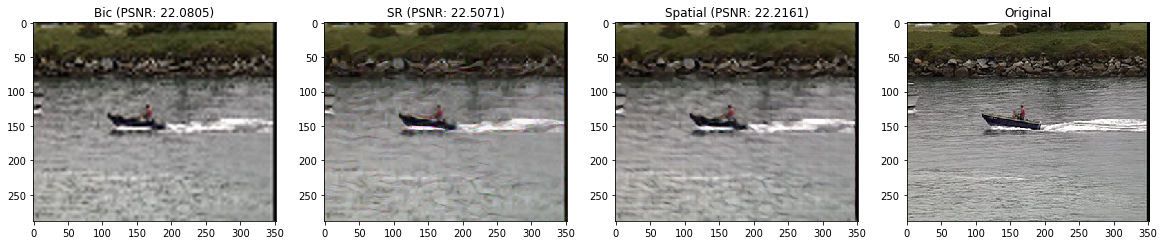

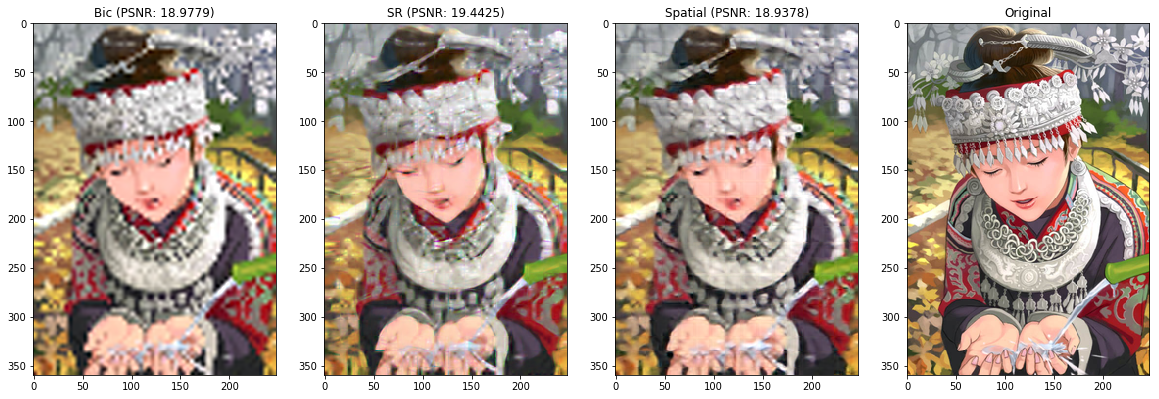

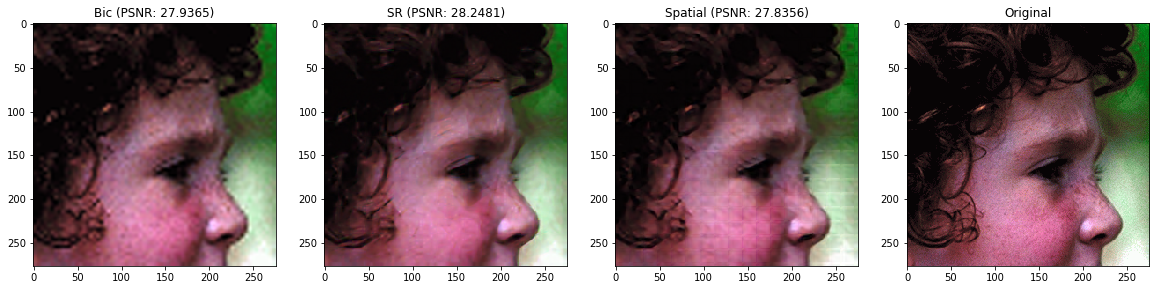

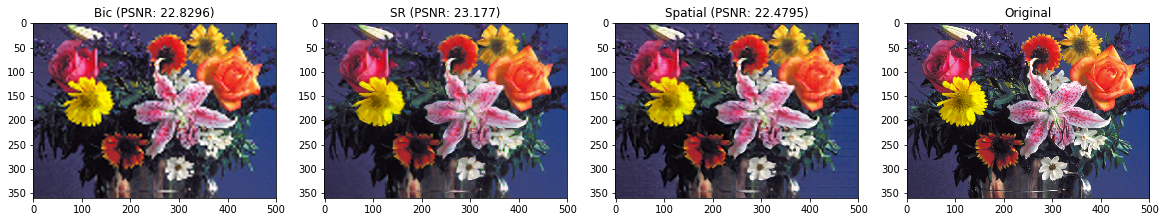

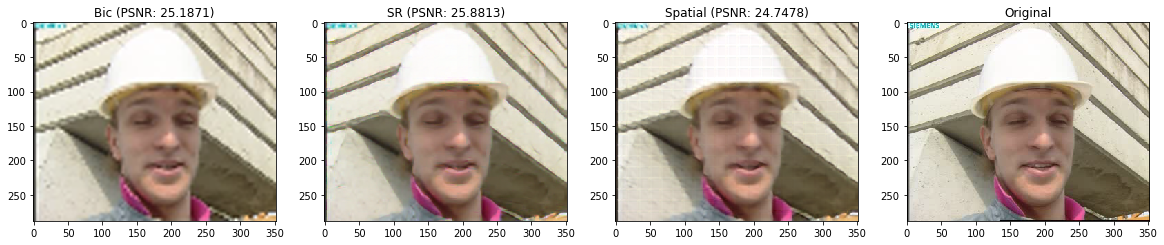

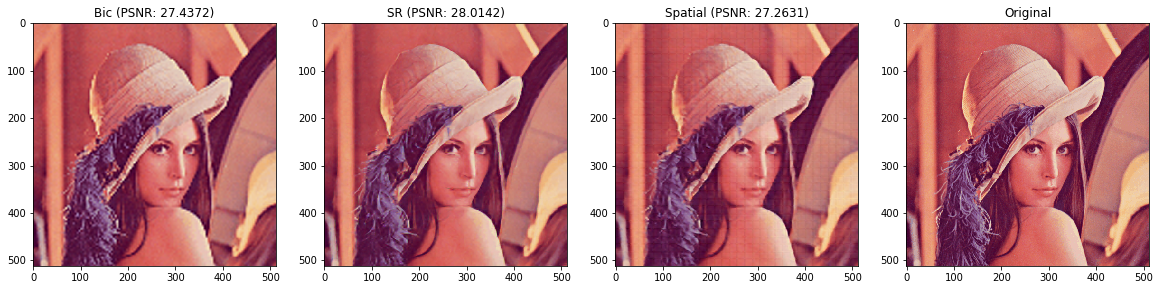

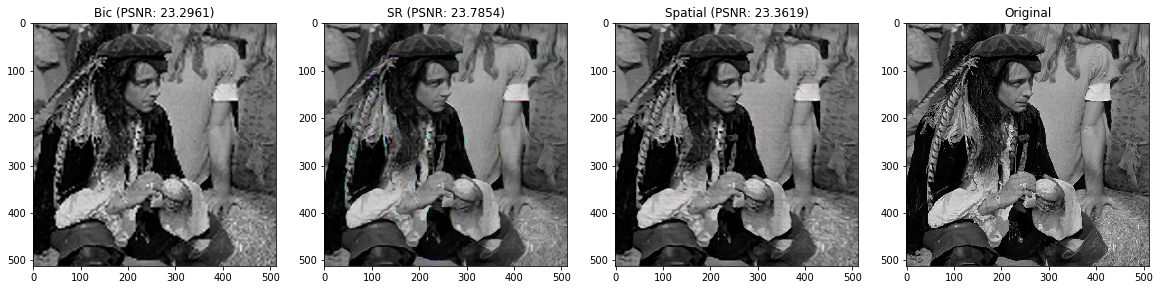

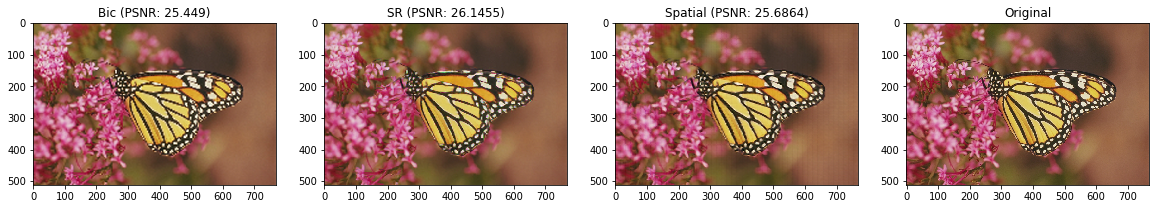

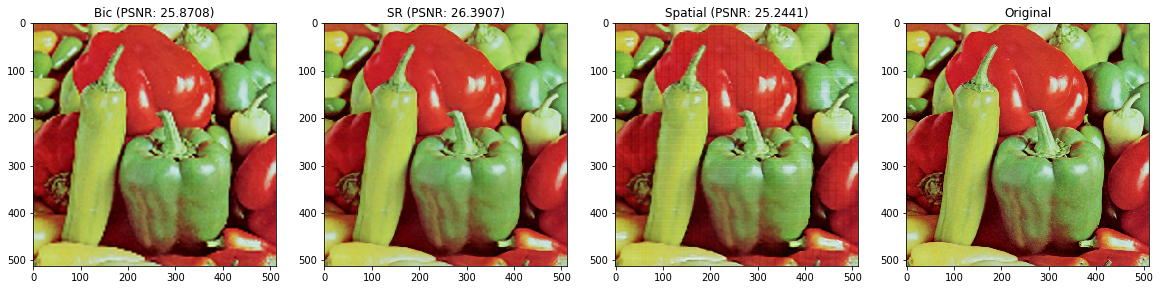

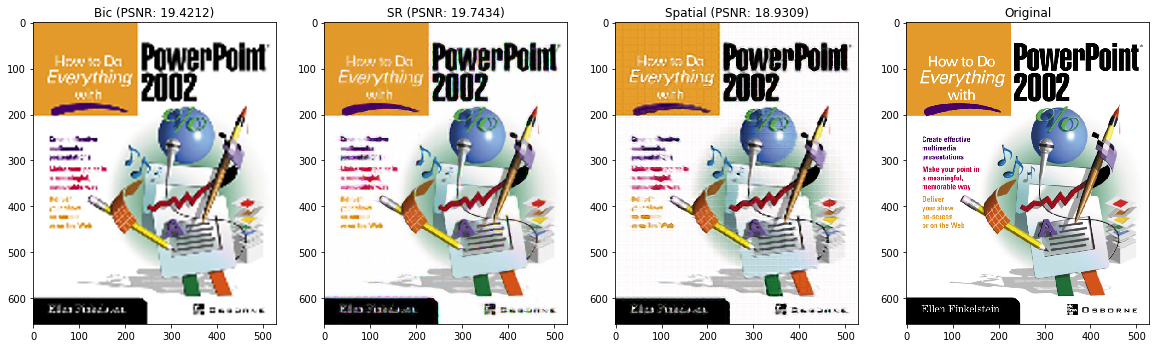

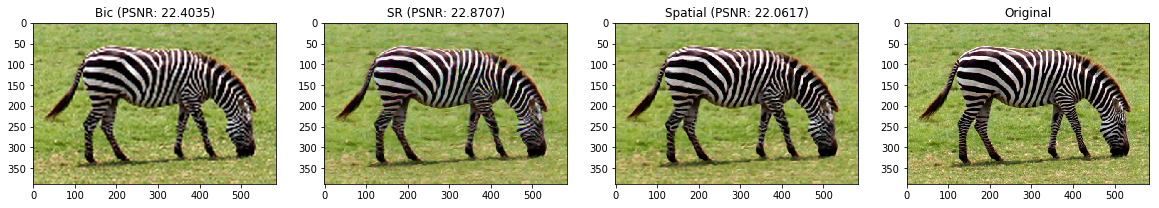

In [18]:
def calcMeasures(i):
    result=results[i]
    org=result[0].astype(float)
    bic=result[1].astype(float)
    sr=result[2].astype(float)
    
    psnr_bic=round(calcPSNR(org,bic),4)
    psnr_sr=round(calcPSNR(org,sr),4)
    
    ssim_bic=round(calcSSIM(org,bic),4)
    ssim_sr=round(calcSSIM(org,sr),4)
    
    mse_bic=round(calcMSE(org,bic),4)
    mse_sr=round(calcMSE(org,sr),4)

    print("Test image: ",i)
    print("")
    print("Bicubic")
    print("PSNR=",psnr_bic)
    print("SSIM=",ssim_bic)
    print("MSE=",mse_bic)
    print("")
    print("SR")
    print("PSNR=",psnr_sr)
    print("SSIM=",ssim_sr)
    print("MSE=",mse_sr)
    print("-------------")

for i in range(14):
    plot_results(i)

In [19]:
for i in range(14):
    calcMeasures(i)

('Test image: ', 0)

Bicubic
('PSNR=', 18.8348)
('SSIM=', 0.4195)
('MSE=', 857.0401)

SR
('PSNR=', 19.354)
('SSIM=', 0.4257)
('MSE=', 760.4735)
-------------
('Test image: ', 1)

Bicubic
('PSNR=', 22.4004)
('SSIM=', 0.6663)
('MSE=', 377.0888)

SR
('PSNR=', 22.5109)
('SSIM=', 0.6688)
('MSE=', 367.6084)
-------------
('Test image: ', 2)

Bicubic
('PSNR=', 21.7392)
('SSIM=', 0.5313)
('MSE=', 439.0974)

SR
('PSNR=', 22.1592)
('SSIM=', 0.5411)
('MSE=', 398.6245)
-------------
('Test image: ', 3)

Bicubic
('PSNR=', 22.0805)
('SSIM=', 0.4791)
('MSE=', 405.9087)

SR
('PSNR=', 22.5071)
('SSIM=', 0.5078)
('MSE=', 367.9346)
-------------
('Test image: ', 4)

Bicubic
('PSNR=', 18.9779)
('SSIM=', 0.6138)
('MSE=', 829.2497)

SR
('PSNR=', 19.4425)
('SSIM=', 0.6199)
('MSE=', 745.1268)
-------------
('Test image: ', 5)

Bicubic
('PSNR=', 27.9365)
('SSIM=', 0.682)
('MSE=', 105.3983)

SR
('PSNR=', 28.2481)
('SSIM=', 0.6884)
('MSE=', 98.1008)
-------------
('Test image: ', 6)

Bicubic
('PSNR=', 22.8296)
(